# monacoBERT + Grad-CAM

In [1]:
import torch, torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

from einops import rearrange

In [2]:
class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers 
    
    ref : https://github.com/jacobgil/pytorch-grad-cam/blob/a701308935d7bc18ec0659eddc95fd6d3e315fd2/pytorch_grad_cam/activations_and_gradients.py#L1
    """
    def __init__(self, model, target_layers):
        self.model = model
        self.gradients = []
        self.activations = []
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()

In [3]:
# config
import torch
import torch.nn as nn

# hyperparameters
gpu_id = 0 if torch.cuda.is_available() else -1
device = torch.device('cuda:1')
max_seq_len = 100
train_ratio = .8
valid_ratio = .1
hidden_size = 512
output_size = 1
num_head = 8
num_encoder = 12
use_leakyrelu = True
dropout_p = .1
learning_rate = 0.001
grad_acc = True
grad_acc_iter = 8

batch_size = 128
n_epochs = 2

In [4]:
# dataloader
from dataloaders.assist2009_pid_diff_loader import ASSIST2009_PID_DIFF
from utils import pid_diff_collate_fn
from torch.utils.data import DataLoader, random_split

dataset = ASSIST2009_PID_DIFF(max_seq_len)
num_q = dataset.num_q
num_r = dataset.num_r
num_pid = dataset.num_pid
num_diff = dataset.num_diff
collate = pid_diff_collate_fn

train_size = int( len(dataset) * train_ratio * (1 - valid_ratio))
valid_size = int( len(dataset) * train_ratio * valid_ratio)
test_size = len(dataset) - (train_size + valid_size)

train_dataset, valid_dataset, test_dataset = random_split(
    dataset, [ train_size, valid_size, test_size ]
    )

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True, # train_loader use shuffle
    collate_fn = collate
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size = batch_size,
    shuffle = False, # valid_loader don't use shuffle
    collate_fn = collate
)
test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False, # test_loader don't use shuffle
    collate_fn = collate
)

In [5]:
%%time
from models.visualizer_monacobert_gradcam import MonaConvBert4ktPlusDiffGradCAM

model = MonaConvBert4ktPlusDiffGradCAM(
    num_q=num_q,
    num_r=num_r,
    num_pid=num_pid,
    num_diff=num_diff,
    hidden_size=hidden_size,
    output_size=output_size,
    num_head=16, # TODO : 16 인데 실제로는 8 임, head_ratio 확인
    num_encoder=num_encoder,
    max_seq_len=max_seq_len,
    device=device,
    use_leakyrelu=use_leakyrelu,
    dropout_p=dropout_p
).to(device)

model_path = '/root/BiDKT/model_records/assist09.pth'
model_dict = torch.load(model_path)
model.load_state_dict(model_dict['model'])

CPU times: user 5.48 s, sys: 1.94 s, total: 7.42 s
Wall time: 7.42 s


<All keys matched successfully>

In [6]:
target_layers = []
for encoder in model.encoder:
    target_layers.extend([encoder.attn.attn_hook_helper, 
                          encoder.attn.conv_hook_helper])
    
# target_layers = [
#     model.emb_q,
#     model.emb_pid,
#     model.emb_diff,
#     model.emb_r,
#     model.emb_p,
# ]
    
gradients_list = []
activations_list = []
valid_sample_list = []

In [7]:
act_and_grad = ActivationsAndGradients(
    model = model, 
    target_layers = target_layers,
)

In [8]:
from torch.nn.functional import binary_cross_entropy
crit = binary_cross_entropy

def gradcam_loss(y_hat, correct):
    correct[correct == 0] = -1
    return (y_hat * correct).mean()

In [9]:
def Mlm4BertTest(r_seqs, mask_seqs):
    #|r_seqs| = (bs, n)

    mlm_r_seqs = []
    mlm_idxs = []

    for r_seq, mask_seq in zip(r_seqs, mask_seqs):
        r_len = r_seq.size(0)

        real_r_seq = torch.masked_select(r_seq, mask_seq).cpu()
        real_r_seq_len = real_r_seq.size(0)

        # last index of real_r_seq
        mlm_idx = real_r_seq_len - 1
        # last index get a <MASK>, <MASK> is 2
        real_r_seq[mlm_idx] = 2

        pad_len = r_len - real_r_seq_len
        pad_seq = torch.full((1, pad_len), 3).squeeze(0) # <PAD> is 3
        pad_r_seq = torch.cat((real_r_seq, pad_seq), dim=-1)
        mlm_r_seqs.append(pad_r_seq)

        mlm_zeros = np.zeros(shape=(r_len, ))
        mlm_zeros[mlm_idx] = 1
        mlm_idxs.append(mlm_zeros)

    mlm_r_seqs = torch.stack(mlm_r_seqs)
    mlm_idxs = torch.BoolTensor(mlm_idxs)

    return mlm_r_seqs, mlm_idxs
    # |mlm_r_seqs| = (bs, n)
    # |mask_seqs| = (bs, n)

In [10]:
from tqdm import tqdm

model.eval()
for batch_idx, data in tqdm(enumerate(test_loader)):
    act_and_grad.gradients = []
    act_and_grad.activations = []
    
    q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs = data

    q_seqs = q_seqs.to(device)
    r_seqs = r_seqs.to(device)
    pid_seqs = pid_seqs.to(device)
    diff_seqs = diff_seqs.to(device)
    mask_seqs = mask_seqs.to(device)

    real_seqs = r_seqs.clone()

    mlm_r_seqs, mlm_idxs = Mlm4BertTest(r_seqs, mask_seqs)

    mlm_r_seqs = mlm_r_seqs.to(device)
    mlm_idxs = mlm_idxs.to(device)

    y_hat = model(
        q_seqs.long(),
        mlm_r_seqs.long(),
        pid_seqs.long(),
        diff_seqs.long(),
        mask_seqs.long()
    )

    y_hat = y_hat.squeeze()

    y_hat = torch.masked_select(y_hat, mlm_idxs)
    correct = torch.masked_select(real_seqs, mlm_idxs)

    # loss = crit(y_hat, correct)
    loss = gradcam_loss(y_hat, correct)
    loss.backward()
    
    # save the result
    batch = mask_seqs.detach().cpu()
    valid_sample_list.append(mask_seqs.detach().cpu())
    
    gradients_list.append(act_and_grad.gradients)
    activations_list.append(act_and_grad.activations)
    assert len(act_and_grad.gradients) == 24
    # assert len(act_and_grad.gradients) == 5

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
9it [00:07,  1.21it/s]


In [11]:
# torch.save(valid_sample_list, 'valid_sample_list.pt')
# torch.save(gradients_list, 'gradients_list.pt')

# torch.save(valid_sample_list, 'emb_valid_sample_list.pt')
# torch.save(gradients_list, 'emb_gradients_list.pt')

# visualization : attn / conv

In [12]:
import torch, torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from einops import rearrange

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [13]:
# valid_sample_list = torch.load('valid_sample_list.pt')
# gradients_list = torch.load('gradients_list.pt')

In [14]:
num_encoder = 12
num_head = 8

In [15]:
from copy import deepcopy

grad_attn_layers = {}
grad_conv_layers = {}

for layer_idx in range(num_encoder):
    grad_attn_layers[f'{layer_idx}'] = 0
    grad_conv_layers[f'{layer_idx}'] = 0
    
    for head_idx in range(num_head):
        grad_attn_layers[f'{layer_idx}-{head_idx}'] = 0
        grad_conv_layers[f'{layer_idx}-{head_idx}'] = 0
        
grad_attn_layers_mean = deepcopy(grad_attn_layers)
grad_conv_layers_mean = deepcopy(grad_conv_layers)

grad_attn_layers_gradcam = deepcopy(grad_attn_layers)
grad_conv_layers_gradcam = deepcopy(grad_conv_layers)

# 
relu = nn.ReLU()
num_samples = 0
for valid_sample, gradients, activations in zip(valid_sample_list, gradients_list, activations_list):
    for seq_idx, seq in tqdm(enumerate(valid_sample)):
        for sample_idx, is_valid_sample in enumerate(seq):
            if bool(is_valid_sample):
                num_samples += 1
                for encoder_idx in range(num_encoder):
                    # grad cam
                    grad_attn = rearrange(gradients[2*encoder_idx], 's i h l -> s i (h l)')[seq_idx, sample_idx]
                    grad_conv = rearrange(gradients[2*encoder_idx+1], 's i h l -> s i (h l)')[seq_idx, sample_idx]

                    acti_attn = rearrange(activations[2*encoder_idx], 's i h l -> s i (h l)')[seq_idx, sample_idx]
                    acti_conv = rearrange(activations[2*encoder_idx+1], 's i h l -> s i (h l)')[seq_idx, sample_idx]
                    
                    denomi = relu(acti_attn * grad_attn).sum() + relu(acti_conv * grad_conv).sum()
                    
                    grad_attn_layers_gradcam[f'{encoder_idx}'] += relu(acti_attn * grad_attn).sum() / denomi
                    grad_conv_layers_gradcam[f'{encoder_idx}'] += relu(acti_conv * grad_conv).sum() / denomi
                    
                    # avg grad cam
#                     attn_importance = relu(acti_attn * grad_attn.mean()).sum()
#                     conv_importance = relu(acti_conv * grad_conv.mean()).sum()
                    
#                     denomi = attn_importance + conv_importance
                    
#                     grad_attn_layers_mean[f'{encoder_idx}'] += attn_importance / denomi
#                     grad_conv_layers_mean[f'{encoder_idx}'] += conv_importance / denomi

128it [00:11, 10.86it/s]
128it [00:10, 11.71it/s]
128it [00:10, 11.82it/s]
128it [00:12, 10.62it/s]
128it [00:10, 11.82it/s]
128it [00:10, 12.05it/s]
128it [00:12, 10.48it/s]
128it [00:10, 12.78it/s]
57it [00:04, 12.51it/s]


In [19]:
# attn = []
# conv = []

attn_mean = []
conv_mean = []

attn_gradcam = []
conv_gradcam = []

for layer_idx in np.arange(0, num_encoder).tolist():
#     attn.append(grad_attn_layers[f'{layer_idx}'].mean())
#     conv.append(grad_conv_layers[f'{layer_idx}'].mean())
    
#     attn_mean.append(grad_attn_layers_mean[f'{layer_idx}'].mean())
#     conv_mean.append(grad_conv_layers_mean[f'{layer_idx}'].mean())
    
    attn_gradcam.append(grad_attn_layers_gradcam[f'{layer_idx}'].mean())
    conv_gradcam.append(grad_conv_layers_gradcam[f'{layer_idx}'].mean())
    
# attn = np.array(attn)
# conv = np.array(conv)
attn_mean = np.array(attn_mean)
conv_mean = np.array(conv_mean)
attn_gradcam = np.array(attn_gradcam)
conv_gradcam = np.array(conv_gradcam)

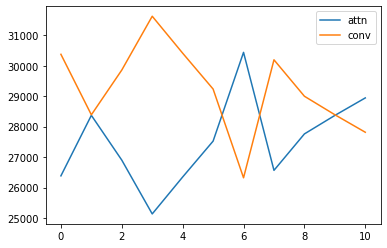

In [58]:
plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(attn_mean, label = 'attn')
plt.plot(conv_mean, label = 'conv')
plt.legend()
plt.show()

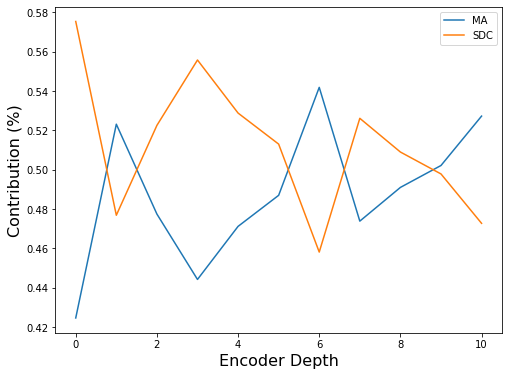

In [20]:
plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(attn_gradcam / (attn_gradcam + conv_gradcam), label = 'MA')
plt.plot(conv_gradcam / (attn_gradcam + conv_gradcam), label = 'SDC')
plt.legend()
plt.xlabel('Encoder Depth', fontsize = 16)
plt.ylabel('Contribution (%)', fontsize = 16)
plt.savefig('../model_records/figure_3_a.pdf')

Text(0, 0.5, 'proportion of positive gradient (%)')

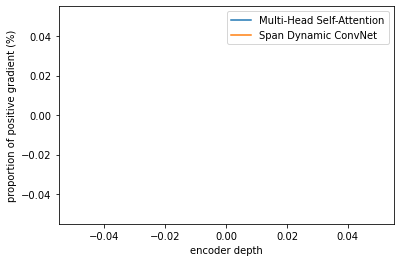

In [57]:
plt.plot(attn / (attn + conv), label = 'Multi-Head Self-Attention')
plt.plot(conv / (attn + conv), label = 'Span Dynamic ConvNet')
plt.legend()
plt.xlabel('encoder depth')
plt.ylabel('proportion of positive gradient (%)')
# plt.savefig('../model_records/attn_conv_positive_gradient.pdf')

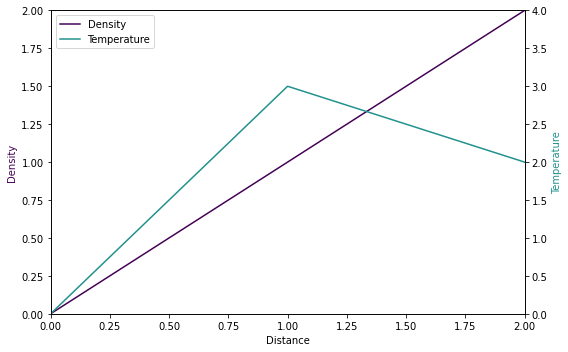

In [64]:
import matplotlib.pyplot as plt 

# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
    
host.set_xlim(0, 2)
host.set_ylim(0, 2)
par1.set_ylim(0, 4)
    
host.set_xlabel("Distance")
host.set_ylabel("Density")
par1.set_ylabel("Temperature")

color1 = plt.cm.viridis(0)
color2 = plt.cm.viridis(0.5)

p1, = host.plot([0, 1, 2], [0, 1, 2], color=color1, label="Density")
p2, = par1.plot([0, 1, 2], [0, 3, 2], color=color2, label="Temperature")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

# Adjust spacings w.r.t. figsize
fig.tight_layout()
# Alternatively: bbox_inches='tight' within the plt.savefig function 
#                (overwrites figsize)

# Best for professional typesetting, e.g. LaTeX
# plt.savefig("pyplot_multiple_y-axis.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'


In [76]:
plt.rcParams["figure.figsize"] = (20,12)
def vis_filter_diff(
    layer_idxs = np.arange(0, num_encoder-1).tolist(),
    save_plot = False,
):
    fig, axs = plt.subplots(len(layer_idxs), 2)
    
    for layer_idx in layer_idxs:
        axs[layer_idx, 0].imshow(grad_attn_layers[f'{layer_idx}'].unsqueeze(0).cpu().numpy(), interpolation='antialiased', aspect='auto')
        axs[layer_idx, 1].imshow(grad_conv_layers[f'{layer_idx}'].unsqueeze(0).cpu().numpy(), interpolation='antialiased', aspect='auto')
        
    if save_plot:
        plt.savefig(f'diff-{diff_idx}_layer_idx-{layer_idx}_head_idx-{head_idx}.png')
    else:
        plt.show()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

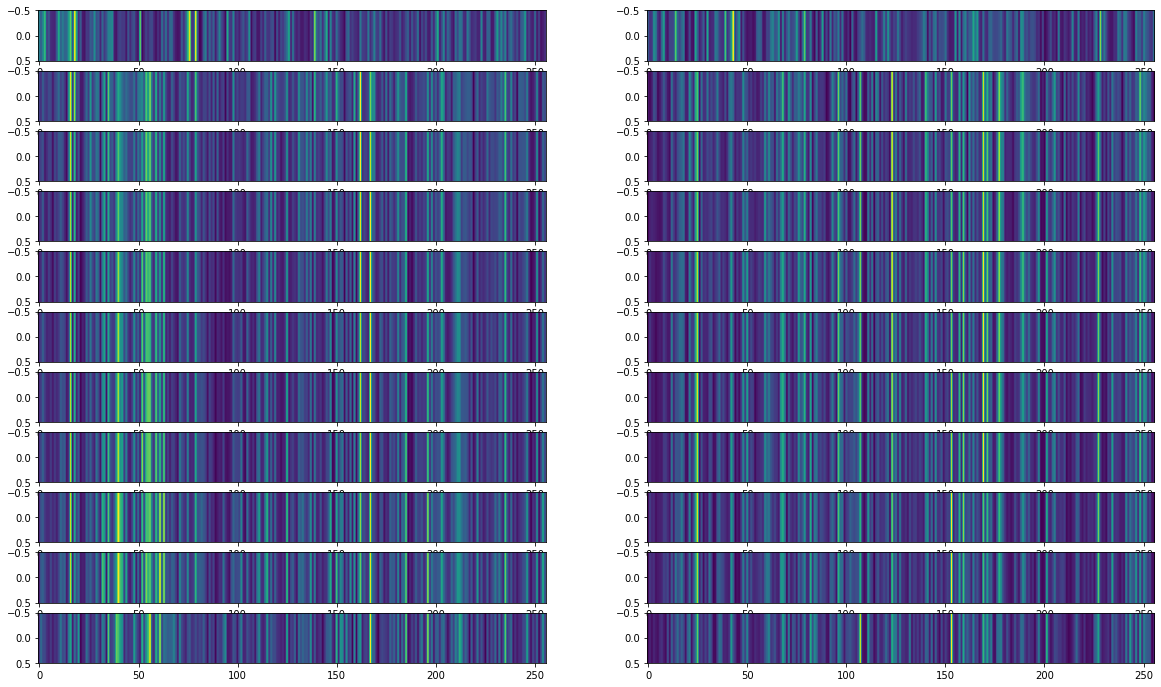

In [77]:
vis_filter_diff()

In [30]:
if bool(is_valid_sample):
    for encoder_idx in range(num_encoder):
        grad_attn = relu(gradients[2*encoder_idx])
        grad_conv = relu(gradients[2*encoder_idx+1])

        grad_attn_layers[f'{encoder_idx}'] += rearrange(grad_attn, 's i h l -> s i (h l)')[seq_idx, sample_idx]
        grad_conv_layers[f'{encoder_idx}'] += rearrange(grad_conv, 's i h l -> s i (h l)')[seq_idx, sample_idx]

In [ ]:
relu = nn.ReLU()
for seq_idx, seq in enumerate(batch):
    for sample_idx, is_valid_sample in enumerate(seq):

        if is_valid_sample is True:
            for encoder_idx in range(num_encoder):
                grad_attn = relu(gradients[2*encoder_idx])
                grad_conv = relu(gradients[2*encoder_idx+1])

                grad_attn_layers[f'{layer_idx}'] += rearrange(grad_attn, 'seq sample head hidden -> seq sample (head hidden)')[seq_idx, sample_idx]
                grad_conv_layers[f'{layer_idx}'] += rearrange(grad_conv, 'seq sample head hidden -> seq sample (head hidden)')[seq_idx, sample_idx]
                for head_idx in range(num_head):
                    grad_attn_layers[f'{layer_idx}-{head_idx}'] += \
                    [grad_attn[seq_idx, sample_idx, head_idx, ...]]
                    grad_conv_layers[f'{layer_idx}-{head_idx}'] += \
                    [grad_conv[seq_idx, sample_idx, head_idx, ...]]

In [ ]:
relu = nn.ReLU()
for seq_idx, seq in tqdm(enumerate(batch)):
    for sample_idx, sample in enumerate(seq):
        q    = int(sample[0])
        r    = int(sample[1])
        pid  = int(sample[2])
        diff = int(sample[3])
        is_mask = bool(sample[4])                
        if is_mask is True:
            for encoder_idx in range(num_encoder):
                grad_attn = relu(gradients[2*encoder_idx])
                grad_conv = relu(gradients[2*encoder_idx+1])

                grad_attn_layers[f'{layer_idx}'] += rearrange(grad_attn, 'seq sample head hidden -> seq sample (head hidden)')[seq_idx, sample_idx]
                grad_conv_layers[f'{layer_idx}'] += rearrange(grad_conv, 'seq sample head hidden -> seq sample (head hidden)')[seq_idx, sample_idx]
                
#                 for head_idx in range(num_head):
#                     grad_attn_layers[f'{layer_idx}-{head_idx}'] += \
#                     [grad_attn[seq_idx, sample_idx, head_idx, ...]]
#                     grad_conv_layers[f'{layer_idx}-{head_idx}'] += \
#                     [grad_conv[seq_idx, sample_idx, head_idx, ...]]

In [12]:
batch = _batch_to_sample(data)
if len(act_and_grad.gradients[2*batch_idx:2*batch_idx+24]) == 24:
    gradients = act_and_grad.gradients[2*batch_idx:2*batch_idx+24]
else:
    gradients = act_and_grad.gradients[2*batch_idx:]

In [14]:
for seq_idx, seq in enumerate(batch):
    for sample_idx, sample in enumerate(seq):
        q    = int(sample[0])
        r    = int(sample[1])
        pid  = int(sample[2])
        diff = int(sample[3])
        is_mask = bool(sample[4])                

        if is_mask is True:
            break

In [18]:
seq_idx

127

In [17]:
gradients[0].shape

torch.Size([57, 100, 8, 32])

In [15]:
for encoder_idx in range(num_encoder):
    for head_idx in range(num_head):
        grad_attn_layers[f'{layer_idx}-{head_idx}'] += \
        [relu(gradients[2*encoder_idx])[seq_idx, sample_idx, head_idx, ...]]
        grad_conv_layers[f'{layer_idx}-{head_idx}'] += \
        [relu(gradients[2*encoder_idx+1][seq_idx, sample_idx, head_idx, ...])]

IndexError: index 127 is out of bounds for dimension 0 with size 57

In [ ]:
1

In [ ]:
print(activation(act_and_grad.gradients[0]).mean())

In [166]:
act_and_grad.gradients[0].shape

torch.Size([32, 100, 8, 32])

In [125]:
act_and_grad.activations[0].shape

torch.Size([32, 100, 8, 32])

384

In [ ]:
def _save_grad_per_sample(batch, act_and_grad, grad_attn_layers, grad_conv_layers):
    for seq_idx, seq in enumerate(batch):
        for sample_idx, sample in enumerate(seq):
            q    = int(sample[0])
            r    = int(sample[1])
            pid  = int(sample[2])
            diff = int(sample[3])
            is_mask = bool(sample[4])                

            print(activation(act_and_grad.gradients[0]).mean())

            if is_mask is True:
                for encoder_idx in range(num_encoder):
                    for head_idx in range(num_head):
                        act_and_grad.gradients[2*encoder_idx][seq_idx][head_idx]
                        act_and_grad.gradients[2*encoder_idx+1][seq_idx]
                        # save 
                        grad_attn_layers[]
                        grad_attn_layers[f'-{head}']
                        grad_conv_layers

                        # save filter
                        self.filter_dict_q[q][encoder_idx]       += [filter_layers[seq_idx, sample_idx, encoder_idx, ...]]
                        self.filter_dict_pid[pid][encoder_idx]   += [filter_layers[seq_idx, sample_idx, encoder_idx, ...]]
                        self.filter_dict_diff[diff][encoder_idx] += [filter_layers[seq_idx, sample_idx, encoder_idx, ...]]

                        # save conv value vector
                        self.conv_value_dict_q[q][encoder_idx]       += [value_layers[seq_idx, sample_idx, encoder_idx, ...]]
                        self.conv_value_dict_pid[pid][encoder_idx]   += [value_layers[seq_idx, sample_idx, encoder_idx, ...]]
                        self.conv_value_dict_diff[diff][encoder_idx] += [value_layers[seq_idx, sample_idx, encoder_idx, ...]]

                        # save attn
                        for head_idx in range(model.encoder[0].attn.num_attention_heads):
                            self.attn_dict[head_idx][encoder_idx] += [attn_layers[seq_idx, encoder_idx, head_idx, ...]]

In [156]:
batch = _split_batch(data)

In [ ]:
def _save_blackbox(self, data):
    '''save attn, filter, conv_value to self.~
    '''

    def _hook_blackbox(attn):
        '''get attn, filter, conv_value from self.model.encoder.attn
        attn_scores : [bs, head_idx, num_seq, num_seq]
        conv_values : [bs, num_seq, head_idx, hidden_dim]
        conv_filter : [bs, num_seq, head_idx, kernel_size]
        '''
        attn_scores = attn.attn_scores 
        conv_values = rearrange(
            attn.conv_value_vectors.detach().clone(), 
            'bs (h_idx h_size) n 1 -> bs n h_idx h_size', h_idx = 8)
        conv_filter = rearrange(
            attn.filters.detach().clone(), 
            '(bs n h) k 1 -> bs n h k', n = 100, h = 8)
        return {'attn' : attn_scores, 'value' : conv_values, 'filter' : conv_filter}

    # organize data, hook to easily get the attr
    batch = [torch.stack([q_seqs.type(torch.long), 
                          r_seqs.type(torch.long), 
                          pid_seqs.type(torch.long), 
                          diff_seqs.type(torch.long), 
                          mask_seqs.type(torch.long)], dim = 1) for q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs in zip(*data)]

    attn_list = [self.model.encoder[encoder_idx].attn for encoder_idx in range(num_encoder)]
    hook_list = list(map(_hook_blackbox, attn_list))

    attn_layers = torch.stack([hook['attn'] for hook in hook_list], dim = 1) # [bs, layer_idx, head_idx, num_seq, num_seq]
    value_layers = torch.stack([hook['value'] for hook in hook_list], dim = 2) # [bs, num_seq, layer_idx, head_idx, hidden_dim]
    filter_layers = torch.stack([hook['filter'] for hook in hook_list], dim = 2) # [bs, num_seq, layer_idx, head_idx, kernel_sizehook_list

    # save hook to self.~
    for seq_idx, seq in enumerate(batch):
        for sample_idx, sample in enumerate(seq):
            q    = int(sample[0])
            r    = int(sample[1])
            pid  = int(sample[2])
            diff = int(sample[3])
            is_mask = bool(sample[4])                

            if is_mask is True:
                for encoder_idx in range(num_encoder):
                    # save filter
                    self.filter_dict_q[q][encoder_idx]       += [filter_layers[seq_idx, sample_idx, encoder_idx, ...]]
                    self.filter_dict_pid[pid][encoder_idx]   += [filter_layers[seq_idx, sample_idx, encoder_idx, ...]]
                    self.filter_dict_diff[diff][encoder_idx] += [filter_layers[seq_idx, sample_idx, encoder_idx, ...]]

                    # save conv value vector
                    self.conv_value_dict_q[q][encoder_idx]       += [value_layers[seq_idx, sample_idx, encoder_idx, ...]]
                    self.conv_value_dict_pid[pid][encoder_idx]   += [value_layers[seq_idx, sample_idx, encoder_idx, ...]]
                    self.conv_value_dict_diff[diff][encoder_idx] += [value_layers[seq_idx, sample_idx, encoder_idx, ...]]

                    # save attn
                    for head_idx in range(model.encoder[0].attn.num_attention_heads):
                        self.attn_dict[head_idx][encoder_idx] += [attn_layers[seq_idx, encoder_idx, head_idx, ...]]

# MNIST + simple CNN example

In [43]:
import torch, torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

import numpy as np

In [44]:
batch_size = 128
num_epochs = 2
device = torch.device('cpu')

In [64]:
# simple cnn
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )
        
        self.hook_helper = HookHelper()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.hook_helper(x)
        x = self.fc_layers(x)
        return x
    
class HookHelper(nn.Module):
    '''custom Module wrapper for register_forward_hook
    '''
    def forward(self, x):
        return x

In [65]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

In [66]:
for batch in train_loader:
    break

In [67]:
cnn = CNN()

In [73]:
act_and_grad = ActivationsAndGradients(
    model = cnn, 
    target_layers = [cnn.conv_layers[2], cnn.conv_layers[6], cnn.hook_helper]
)

In [74]:
output = act_and_grad(batch[0])

In [52]:
class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.gradients = []
        self.activations = []
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()


In [49]:
def save_activation(module, input, output):
    global activations
    activation = output
    activations.append(activation.cpu().detach())

def save_gradient(module, input, output):
    if not hasattr(output, "requires_grad") or not output.requires_grad:
        # You can only register hooks on tensor requires grad.
        return

    # Gradients are computed in reverse order
    def _store_grad(grad):
        gradients = [grad.cpu().detach()] + gradients

    output.register_hook(_store_grad)

In [41]:
## instance input
model = cnn
target_layers = [cnn.conv_layers[2], cnn.conv_layers[6]]

## init
gradients = []
activations = []
handles = []
for target_layer in target_layers:
    handles.append(target_layer.register_forward_hook(save_activation))
    handles.append(target_layer.register_forward_hook(save_gradient))

In [42]:
## call
cnn(batch[0])

TypeError: save_activation() missing 1 required positional argument: 'output'

In [ ]:
def __call__(self, x):
    self.gradients = []
    self.activations = []
    return self.model(x)

def release(self):
    for handle in self.handles:
        handle.remove()

In [ ]:
for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))

In [21]:
output = cnn(batch[0])

ReLU()

ReLU()

In [ ]:
activations_and_grads = ActivationsAndGradients(cnn, [cnn.conv_layers[2], cnn.conv_layers[6]])

In [ ]:
class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.gradients = []
        self.activations = []
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()


In [ ]:
# backward + 

# GRAD CAM